In [ ]:
!pip install yfinance matplotlib seaborn scikit-learn tensorflow


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0354 - val_loss: 4.3816e-04
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0017 - val_loss: 2.5387e-04
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0017 - val_loss: 4.1389e-05
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0011 - val_loss: 4.9519e-04
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0015 - val_loss: 4.0177e-04
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0011 - val_loss: 4.9230e-05
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 9.4057e-04 - val_loss: 4.2596e-04
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0010 - val_loss: 2.3676e-05
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 8.1430e-04 - val_loss: 0.0016
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Root Mean Squared Error: 58.68


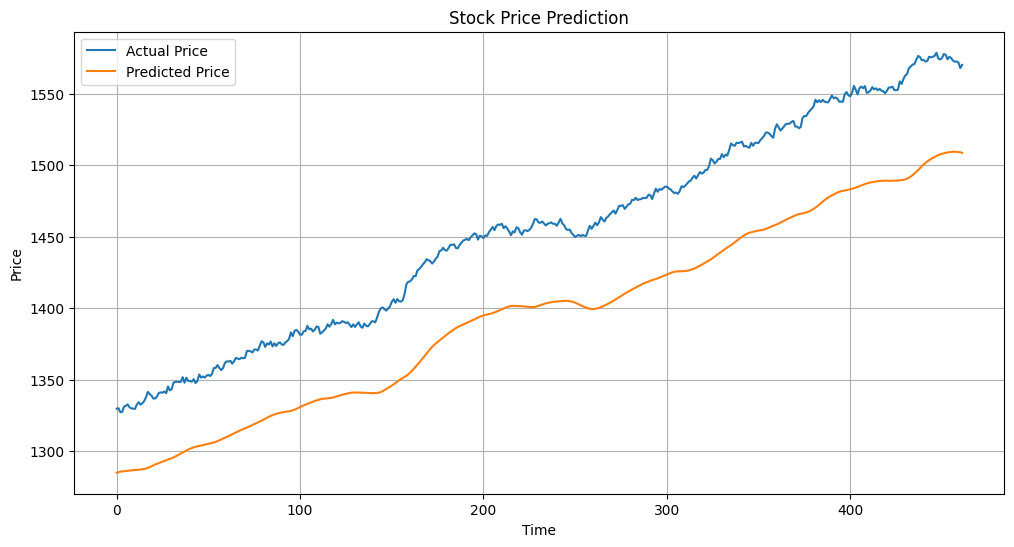

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv('AAPL_sample_stock_data.csv', index_col='Date', parse_dates=True)
data = data[['Close']]
data.dropna(inplace=True)


if not data.empty:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
else:
    raise ValueError("Dataset is empty. Please check your CSV file.")


training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error: {rmse:.2f}")


plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
